# 算法性能中偏差和方差的概念
## 案例：利用水库水位变化预测大坝出水量
### 数据集：ex5data.mat

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import minimize

In [2]:
data = loadmat('ex5data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])

In [3]:
# 训练集
X_train,y_train = data['X'],data['y']
X_train.shape,y_train.shape

((12, 1), (12, 1))

In [4]:
# 验证集
X_val,y_val = data['Xval'],data['yval']
X_val.shape,y_val.shape

((21, 1), (21, 1))

In [5]:
# 测试集
X_test,y_test = data['Xtest'],data['ytest']
X_test.shape,y_test.shape

((21, 1), (21, 1))

In [6]:
X_train = np.insert(X_train,0,1,axis=1)
X_val = np.insert(X_val,0,1,axis=1)
X_test = np.insert(X_test,0,1,axis=1)

In [7]:
def plot_data():
    fig,ax = plt.subplots()
    ax.scatter(X_train[:,1],y_train)
    ax.set(xlabel='change in water level(x)',
          ylabel='water flowing out on the dam(y)')

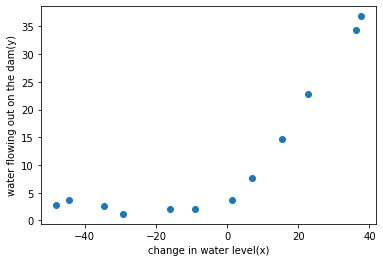

In [8]:
plot_data()

In [9]:
def reg_cost(theta,X,y,lamda):
    
    cost = np.sum(np.power((X @ theta - y.flatten()),2))
    reg = theta[1:] @ theta[1:] * lamda
    
    return (cost + reg) / (2 * len(X))

In [10]:
def reg_gradient(theta,X,y,lamda):
    
    grad = (X @ theta - y.flatten()) @ X
    reg = lamda * theta
    reg[0] = 0
    
    return (grad + reg) / len(X)

In [11]:
def train_model(X,y,lamda):
    
    theta = np.ones(X.shape[1])
    res = minimize(fun=reg_cost,
                  x0=theta,
                  args=(X,y,lamda),
                  method='TNC',
                  jac=reg_gradient)
    
    return res.x

In [12]:
theta_final = train_model(X_train,y_train,lamda=0)

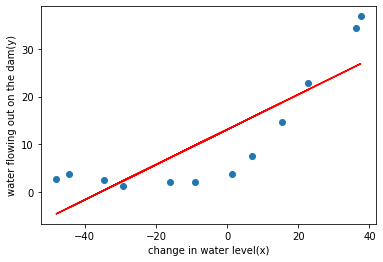

In [14]:
plot_data()
plt.plot(X_train[:,1],X_train @ theta_final,c='r')
plt.show()

### 让训练样本从1开始递增进行训练，比较训练集和验证集上损失函数的变化情况（学习曲线）

In [15]:
def plot_learning_curve(X_train,y_train,X_val,y_val,lamda):
    
    x = range(1,len(X_train)+1)
    training_cost = []
    cv_cost = []
    
    for i in x:
        
        res = train_model(X_train[:i,:],y_train[:i,:],lamda)
        training_cost_i = reg_cost(res,X_train[:i,:],y_train[:i,:],lamda)
        cv_cost_i = reg_cost(res,X_val,y_val,lamda)
        training_cost.append(training_cost_i)
        cv_cost.append(cv_cost_i)
        
    plt.plot(x,training_cost,label='training cost')
    plt.plot(x,cv_cost,label='cv cost')
    plt.legend()
    plt.xlabel('numbers of training examples')
    plt.ylabel('error')
    plt.show()

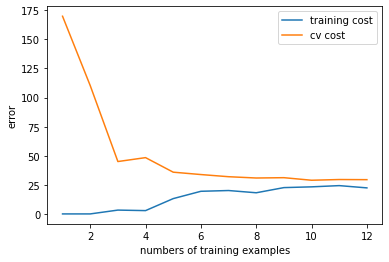

In [16]:
plot_learning_curve(X_train,y_train,X_val,y_val,lamda=0)

### 模型表现为高偏差（欠拟合）

In [31]:
def poly_feature(X,power):
    """构造多项式特征"""
    for i in range(2,power+1):
        X = np.insert(X,X.shape[1],np.power(X[:,1],i),axis=1)
    
    return X
        

In [32]:
def get_means_stds(X):
    """获取均值和方差"""
    means = np.mean(X,axis=0)
    stds = np.std(X,axis=0)
    
    return means,stds

In [33]:
def feature_normalize(X,means,stds):
    """归一化特征"""
    X[:,1:] = (X[:,1:] - means[1:]) / stds[1:]
    
    return X

In [34]:
power = 6

In [35]:
X_train_poly = poly_feature(X_train,power)
X_val_poly = poly_feature(X_val,power)
X_test_poly = poly_feature(X_test,power)

In [36]:
train_means,train_stds = get_means_stds(X_train_poly)

In [37]:
X_train_norm = feature_normalize(X_train_poly,train_means,train_stds)
# 验证集和测试集归一化也是采用训练集的均值和方差进行
X_val_norm = feature_normalize(X_val_poly,train_means,train_stds)
X_test_norm = feature_normalize(X_test_poly,train_means,train_stds)

In [38]:
theta_fit = train_model(X_train_norm,y_train,lamda=0)

In [39]:
def plot_poly_fit():
    plot_data()
    
    x = np.linspace(-60,60,100)
    xx = x.reshape(100,1)
    xx = np.insert(xx,0,1,axis=1)
    xx = poly_feature(xx,power)
    xx = feature_normalize(xx,train_means,train_stds)
    
    plt.plot(x,xx @ theta_fit,'r--')

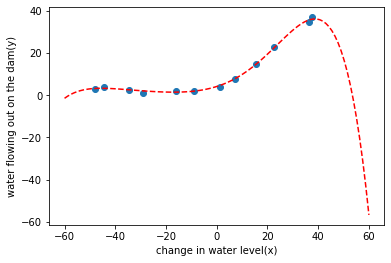

In [40]:
plot_poly_fit()

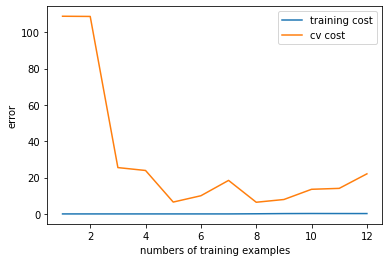

In [41]:
plot_learning_curve(X_train_norm,y_train,X_val_norm,y_val,lamda=0)

### 模型表现为高方差（过拟合）

### 加入正则化

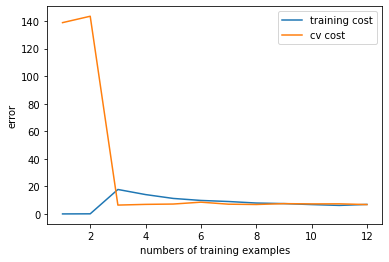

In [42]:
plot_learning_curve(X_train_norm,y_train,X_val_norm,y_val,lamda=1)

### 此时模型表现较好